### Look at first run results

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.grid import region_mask, single_cavity_mask, calc_geometry
from nemo_python_git.constants import region_names, deg_string, gkg_string, region_points
from nemo_python_git.plots import timeseries_by_region
import imageio
import glob
import matplotlib.path as mpath
import cmocean
import tqdm
import os

In [3]:
# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

In [4]:
def prepare_plot(figsize=(15, 8)):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig, ax = plt.subplots(1,2, figsize=figsize, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    for axis in ax.ravel():
        axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        axis.set_boundary(map_circle, transform=axis.transAxes)
        # ax.coastlines(); 
        gl = axis.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [5]:
# tmask = np.ma.masked_where(mesh.tmask.values==0, mesh.tmask.values)

In [14]:
def plot_2D_circumpolar(fileT, month, depth, path='.', save=True, Tmin=-4, Tmax=4):

    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True, 'vmin':Tmin, 'vmax':Tmax}
    kwags2  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.haline, 'rasterized':True, 'vmin':33, 'vmax':35.5}
    fig, ax = prepare_plot()
    cm1 = ax[0].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.thetao.isel(time_counter=month-1, deptht=depth), **kwags1)
    ax[0].add_feature(cfeature.LAND, color='w', zorder=3)
    cm2 = ax[1].pcolormesh(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, fileT.so.isel(time_counter=month-1, deptht=depth), **kwags2)
    ax[1].add_feature(cfeature.LAND, color='w', zorder=3)
    CB1 = fig.colorbar(cm1, ax=ax[0], fraction=0.04)
    CB1.set_label(fileT.thetao.long_name)
    CB2 = fig.colorbar(cm2, ax=ax[1], fraction=0.04)
    CB2.set_label(fileT.so.long_name)

    date = fileT.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    year = str(date)[:-3]
    fig.suptitle(f"{str(date)}, depth: {mesh.nav_lev.values[depth]:.1f} m")
    
    if save:
        fig.savefig(f'{path}circumpolar_y{year}m{month:02}z{depth:03}.jpg', bbox_inches='tight')

    plt.close(fig)
    
    return

In [15]:
def create_animation(filenames, out_file='test.mp4'):
    
    # filenames is a list of the names/locations of image files to combine into animation (mp4 in this case)
    with imageio.get_writer(f'{out_file}', fps=2, mode='I') as writer: 
        for filename in filenames:  
            image = imageio.imread(filename)  
            writer.append_data(image)
    return

In [20]:
def amundsen_frame(fileT_ini, var, month, path):
    depth_ind = [0, 18, 35]
    fileT    = fileT_ini.isel(x_grid_T=slice(500, 900), y_grid_T=slice(150,350))
    mesh_sub = mesh.isel(x=slice(500, 900), y=slice(150,350))
    
    # --------- figure -------------------------------------------------------------
    fig  = plt.figure(figsize=(18,8))
    date = fileT_ini.time_counter.isel(time_counter=month-1).dt.strftime('%Y-%m').values
    fig.suptitle(f"{str(date)}")
    gs = fig.add_gridspec(3,5)
    
    ax1 = fig.add_subplot(gs[0, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax2 = fig.add_subplot(gs[1, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax3 = fig.add_subplot(gs[2, 0:3], projection=ccrs.Mercator(latitude_true_scale=-70))
    ax4 = fig.add_subplot(gs[:, 3]) # temperature
    ax5 = fig.add_subplot(gs[:, 4]) # salinity
    
    vm = [(-2.5, 2.5),(-2.5,2.5),(-2.5,2.5)] # colorbar limits
    # vm = [(31, 34.5),(31,34.5),(34.4,35)] # colorbar limits
    # Coordinates of 'stations'
    i1, i2 = (249, 715) # on Amundsen shelf
    s1, s2 = (271, 711) # Amundsen shelf break
    o1, o2 = (281, 711) # off Amundsen slope
    lon    = mesh.nav_lon.values
    lat    = mesh.nav_lat.values
    
    # --- Maps ---
    kwags1  = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}
    for i, axis in enumerate([ax1, ax2, ax3]):
        axis.set_extent([-80, -140, -75.5, -68], ccrs.PlateCarree())
        axis.set_title(f'{fileT[var].long_name}, depth: {mesh.nav_lev.values[depth_ind[i]]:.1f} m')
        lon_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lon_grid_T.values)
        lat_plot = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT.nav_lat_grid_T.values)
        plot_var = np.ma.masked_where(mesh_sub.tmask.isel(nav_lev=depth_ind[i]) == 0, fileT[var].isel(time_counter=month-1, deptht=depth_ind[i]).values)
        cm = axis.pcolormesh(lon_plot, lat_plot, plot_var, vmin=vm[i][0], vmax=vm[i][1], **kwags1)
    
        # mark shelf break with dashed line
        axis.contour(fileT.nav_lon_grid_T, fileT.nav_lat_grid_T, mesh_sub.bathy_metry, [1200], 
                     linestyles='--', linewidths=0.8, colors='k', transform=ccrs.PlateCarree(), zorder=3)
    
        stn_kwags = {'transform':ccrs.PlateCarree(), 'marker':'*', 's':90, 'zorder':3, 'edgecolors':'k', 'linewidths':0.6}
        axis.scatter([lon[i1,i2], lon[i1,i2]], [lat[i1,i2], lat[i1,i2]], **stn_kwags)
        axis.scatter([lon[s1,s2], lon[s1,s2]], [lat[s1,s2], lat[s1,s2]], **stn_kwags)
        axis.scatter([lon[o1,o2], lon[o1,o2]], [lat[o1,o2], lat[o1,o2]], **stn_kwags)
        CB1 = fig.colorbar(cm, ax=axis, fraction=0.04)

        gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False; gl.right_labels = False;
        gl.xlines = False; gl.ylines = False;
        
    # --- profiles ---
    ax4.set_xlim(-2.5, 2.5)
    ax5.set_xlim(32.5, 35)
    vars = ['thetao', 'so']
    for i, axis in enumerate([ax4, ax5]):
        axis.invert_yaxis()
        axis.set_ylim(600, 0)
        plot1 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=i1, x_grid_T=i2))
        plot2 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=s1, x_grid_T=s2))
        plot3 = xr.where(fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2) == 0, np.nan, 
                         fileT_ini[vars[i]].isel(time_counter=month-1, y_grid_T=o1, x_grid_T=o2))
        axis.set_title(fileT_ini[vars[i]].long_name)
        axis.plot(plot1, mesh.nav_lev, label='Shelf')
        axis.plot(plot2, mesh.nav_lev, label='Shelf break')
        axis.plot(plot3, mesh.nav_lev, label='Open ocean')
        
        for di in depth_ind:
            axis.plot([-10, 40],[mesh.nav_lev.values[di], mesh.nav_lev.values[di]], '--k')
        axis.set_ylabel('Depth (m)')
        axis.legend(frameon=False, loc=(0.1, 0.05), fontsize=12)
    
    fig.tight_layout()
    fig.savefig(f'{path}amundsen_{var}_y{str(date)[:-3]}m{month:02}.jpg', bbox_inches='tight')
    plt.close(fig)
    return

In [17]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240201.nc').isel(time_counter=0)

In [21]:
var='so'

run_path  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
for year in range(1979,2011):
    fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for month in range(1,13):
        amundsen_frame(fileT, var, month, run_path+'temp/')

# filenames=glob.glob(f'{run_path}temp/amundsen_{var}_y????m??.jpg')

# create_animation(filenames, out_file=f'{run_path}amundsen-so.mp4')

In [ ]:
run_path = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

for year in range(1979,1988):
    fileT = xr.open_dataset(run_path + f'eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc')
    for depth in [0, 20, 50]:
        for month in range(1,13):
            plot_2D_circumpolar(fileT, month, depth, path=run_path+'temp/')

for depth in [0, 20, 50]:
    filenames=glob.glob(f'{run_path}temp/circumpolar_y????m??z{depth:03}.jpg')        
    create_animation(filenames, out_file=f'{run_path}circumpolar_monthly_z{depth:03}.mp4')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,10), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)})

for axis in ax.ravel():
    axis.set_extent([-90, -160, -78, -64], ccrs.PlateCarree())
    cs = axis.contour(SOSE_sal_jan.XC, SOSE_sal_jan.YC, SOSE_sal_jan.Depth, levels=[1000, 2000], 
                      colors='w', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;
    
cm1 = ax[0,0].pcolormesh(WOA_sal.lon, WOA_sal.lat, WOA_sal.s_an.isel(time=0), 
                             transform=ccrs.PlateCarree(), vmin=31, vmax=34)
# CB1 = fig.colorbar(cm1, ax=ax[0,0], fraction=0.03, label='Sea water salinity at standard depths (g/kg)')

Check drift in near-bottom temperature and salinity by region:

In [5]:
nemo_mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240201.nc')

In [6]:
def calc_timeseries(var, ds_nemo, domain_cfg='/gws/nopw/j04/terrafirma/kaight/input_data/grids/domcfg_eORCA1v2.2x.nc', halo=True):

    nemo_mesh = xr.open_dataset(domain_cfg)
    
    # Parse variable name
    factor = 1
    region_type = None
    region = None
    if var.endswith('_bwtemp'):
        option = 'area_avg'
        region = var[:var.index('_bwtemp')]
        nemo_var = 'tob'
        units = deg_string+'C'
        title = 'Bottom temperature'
    elif var.endswith('_bwsalt'):
        option = 'area_avg'
        region = var[:var.index('_bwsalt')]
        nemo_var = 'sob'
        units = gkg_string
        title = 'Bottom salinity'

    # Select region
    if region is not None:
        if region_type is None:
            if region.endswith('cavity'):
                region = region[:region.index('_cavity')]
                region_type = 'cavity'
            elif region.endswith('shelf'):
                region = region[:region.index('_shelf')]
                region_type = 'shelf'
            else:
                region_type = 'all'
        if region in region_points and region_type == 'cavity':
            # Single ice shelf
            mask, _, region_name = single_cavity_mask(region, nemo_mesh, return_name=True)
        else:
            mask, _, region_name = region_mask(region, nemo_mesh, option=region_type, return_name=True)
        title += ' for '+region_name    
        
    if option == 'area_int':
        # Area integral
        dA = ds_nemo['area']*mask
        data = (ds_nemo[nemo_var]*dA).sum(dim=['x','y'])
    elif option == 'area_avg':
        # Area average
        dA = ds_nemo['area']*mask
        if nemo_var == 'draft':
            data_xy = calc_geometry(ds_nemo, keep_time_dim=True)[1]
        else:
            data_xy = ds_nemo[nemo_var]
        data = (data_xy*dA).sum(dim=['x','y'])/dA.sum(dim=['x','y'])
        
    data *= factor
    data = data.assign_attrs(long_name=title, units=units)

    return data, ds_nemo

In [ ]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

ts_bwtemp = {}; ts_bwsalt = {};
for year in range(1979, 2011):
    print(year)
    with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc') as file:
        # Need to rename some of the variables to work with the calc_timeseries function, and compress
        file      = file.rename({'sbt':'tob', 'sbs':'sob'})
        file_comp = file.get(['time_centered', 'time_counter', 'deptht','tob', 'sob'])
        file_comp['sob']  = ('time_counter', 'y', 'x'), file_comp['sob'].values
        file_comp['tob']  = ('time_counter', 'y', 'x'), file_comp['tob'].values
        file_comp['area'] = ('y', 'x'), file['area_grid_T'].values

        for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
            ts_bwt, _ = calc_timeseries(f'{name}_bwtemp', file_comp, 
                                              domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc', halo=False)
            ts_bws, _ = calc_timeseries(f'{name}_bwsalt', file_comp, 
                                              domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc', halo=False)

            if year==1979:
                ts_bwtemp[name] = ts_bwt        
                ts_bwsalt[name] = ts_bws
            else:
                ts_bwtemp[name] = xr.concat([ts_bwtemp[name], ts_bwt], dim='time_counter')
                ts_bwsalt[name] = xr.concat([ts_bwsalt[name], ts_bws], dim='time_counter')

1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


In [9]:
colors = ['#00CB98','#059fdc','#ffd200','#f28800','#e34e59','#5b5496','k']

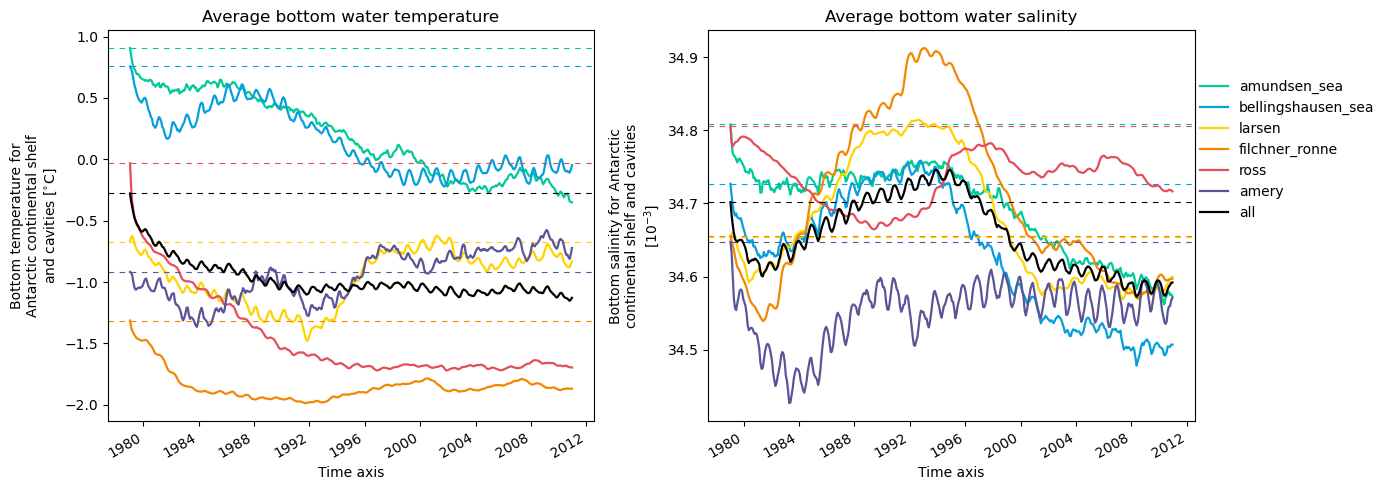

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,5))

for i, name in enumerate(['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross','amery','all']):
    ax[0].axhline(y=ts_bwtemp[name].isel(time_counter=0).values, linestyle='--', color=colors[i], linewidth=0.8, dashes=(5, 5))
    ts_bwtemp[name].plot(ax=ax[0], label=name, color=colors[i], linewidth=1.6)
    ax[1].axhline(y=ts_bwsalt[name].isel(time_counter=0).values, linestyle='--', color=colors[i], linewidth=0.8, dashes=(5, 5))
    ts_bwsalt[name].plot(ax=ax[1], label=name, color=colors[i], linewidth=1.6)
    
ax[0].set_title('Average bottom water temperature')
ax[1].set_title('Average bottom water salinity')
ax[1].legend(frameon=False, loc=(1.0, 0.5))
fig.tight_layout()
# ax[1].plot(ts_amundsen_bwalt)

Also look at:
- SSH drift in full domain
- T, S thermocline drift

In [7]:
def create_regions_file(nemo_mesh, option, out_file):

    ds = xr.Dataset(
        coords={'nav_lon':(["y","x"], nemo_mesh.nav_lon.values),
                'nav_lat':(["y","x"], nemo_mesh.nav_lat.values)})
    
    masks={}
    # later should be for name in region_names
    for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
        mask, _, region_name = region_mask(name, nemo_mesh, option=option, return_name=True) 
        masks[name] = mask 
        ds = ds.assign({f'mask_{name}':(["y","x"], masks[name].values)})   
    
    ds.to_netcdf(out_file)
    
    return ds

In [26]:
ds_nem

<xarray.Dataset>
Dimensions:                (y_grid_T: 453, x_grid_T: 1440, nvertex_grid_T: 4,
                            deptht: 121, axis_nbounds: 2, time_counter: 12,
                            y_grid_T_inner: 453, x_grid_T_inner: 1440)
Coordinates:
    nav_lat_grid_T         (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T         (y_grid_T, x_grid_T) float32 ...
  * deptht                 (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_centered          (time_counter) datetime64[ns] ...
  * time_counter           (time_counter) datetime64[ns] 1979-01-16T12:00:00 ...
Dimensions without coordinates: y_grid_T, x_grid_T, nvertex_grid_T,
                                axis_nbounds, y_grid_T_inner, x_grid_T_inner
Data variables: (12/15)
    bounds_nav_lon_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    bounds_nav_lat_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    area_grid_T            (y_grid_T, x_grid_T) float32 1e+06 ... 3.185e+08
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    time_centered_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds    (time_counter, axis_nbounds) datetime64[ns] ...
    ...                     ...
    zos                    (time_counter, y_grid_T, x_grid_T) float32 ...
    mldr10_1               (time_counter, y_grid_T, x_grid_T) float32 ...
    tob                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sbs                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sosst                  (time_counter, y_grid_T, x_grid_T) float32 ...
    sosss                  (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    name:         eANT025.L121_1m_19790101_19791231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Feb-05 14:39:06 GMT
    uuid:         edf880d5-7033-45f6-a9cb-8e1b67c1930d

In [ ]:
create_regions_file(nemo_mesh, 'all'   , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')
create_regions_file(nemo_mesh, 'shelf' , '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_shelf.nc')
create_regions_file(nemo_mesh, 'cavity', '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_cavity.nc')

In [3]:
ant_regions = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/regions_all.nc')

In [25]:
timeseries_file = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/timeseries.nc'

In [11]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'
year=1979
ds_nem  = xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').rename({'sbt':'tob'})
ds_nemo = ds_nem.get(['time_centered', 'time_counter', 'deptht', 'tob'])
ds_nemo['tob']  = ('time_counter', 'y', 'x'), ds_nem['tob'].values
ds_nemo['area'] = ('y', 'x'), ds_nem['area_grid_T'].values

In [23]:
if 's':
    print('empty')

empty


In [24]:
ds_nem

<xarray.Dataset>
Dimensions:                (y_grid_T: 453, x_grid_T: 1440, nvertex_grid_T: 4,
                            deptht: 121, axis_nbounds: 2, time_counter: 12,
                            y_grid_T_inner: 453, x_grid_T_inner: 1440)
Coordinates:
    nav_lat_grid_T         (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T         (y_grid_T, x_grid_T) float32 ...
  * deptht                 (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_centered          (time_counter) datetime64[ns] ...
  * time_counter           (time_counter) datetime64[ns] 1979-01-16T12:00:00 ...
Dimensions without coordinates: y_grid_T, x_grid_T, nvertex_grid_T,
                                axis_nbounds, y_grid_T_inner, x_grid_T_inner
Data variables: (12/15)
    bounds_nav_lon_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    bounds_nav_lat_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    area_grid_T            (y_grid_T, x_grid_T) float32 1e+06 ... 3.185e+08
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    time_centered_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds    (time_counter, axis_nbounds) datetime64[ns] ...
    ...                     ...
    zos                    (time_counter, y_grid_T, x_grid_T) float32 ...
    mldr10_1               (time_counter, y_grid_T, x_grid_T) float32 ...
    tob                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sbs                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sosst                  (time_counter, y_grid_T, x_grid_T) float32 ...
    sosss                  (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    name:         eANT025.L121_1m_19790101_19791231_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Feb-05 14:39:06 GMT
    uuid:         edf880d5-7033-45f6-a9cb-8e1b67c1930d

In [33]:
region_names = ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']
vars = '_bwtemp'
precompute_timeseries(ds_nemo, ['amundsen_sea_bwtemp'], timeseries_file, 
                      domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc', halo=False, pp=False)

In [12]:
update_simulation_timeseries('eANT025', 'L121', ['amundsen_sea_bwtemp'], timeseries_file='timeseries.nc', 
                             sim_dir='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/', 
                             freq='m', halo=False, gtype='T', domain_cfg='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc')

['eANT025.L121_1m_19800101_19801231*_T.nc', 'eANT025.L121_1m_19810101_19811231*_T.nc', 'eANT025.L121_1m_19820101_19821231*_T.nc', 'eANT025.L121_1m_19830101_19831231*_T.nc', 'eANT025.L121_1m_19840101_19841231*_T.nc', 'eANT025.L121_1m_19850101_19851231*_T.nc', 'eANT025.L121_1m_19860101_19861231*_T.nc', 'eANT025.L121_1m_19870101_19871231*_T.nc', 'eANT025.L121_1m_19880101_19881231*_T.nc', 'eANT025.L121_1m_19890101_19891231*_T.nc', 'eANT025.L121_1m_19900101_19901231*_T.nc', 'eANT025.L121_1m_19910101_19911231*_T.nc', 'eANT025.L121_1m_19920101_19921231*_T.nc', 'eANT025.L121_1m_19930101_19931231*_T.nc', 'eANT025.L121_1m_19940101_19941231*_T.nc', 'eANT025.L121_1m_19950101_19951231*_T.nc', 'eANT025.L121_1m_19960101_19961231*_T.nc', 'eANT025.L121_1m_19970101_19971231*_T.nc', 'eANT025.L121_1m_19980101_19981231*_T.nc', 'eANT025.L121_1m_19990101_19991231*_T.nc', 'eANT025.L121_1m_20000101_20001231*_T.nc', 'eANT025.L121_1m_20010101_20011231*_T.nc', 'eANT025.L121_1m_20020101_20021231*_T.nc', 'eANT025.L

KeyError: 'area'

In [11]:
# Precompute timeseries from the given simulation, either from the beginning (timeseries_file does not exist) or picking up where it left off 
# (timeseries_file does exist). Considers all NEMO output files stamped with suite_id in the given directory sim_dir on the given grid (gtype='T', 'U', etc),
# and assumes the timeseries file is in that directory too.
def update_simulation_timeseries(suite_id, timeseries_types, config='', timeseries_file='timeseries.nc', sim_dir='./', 
                                 freq='m', halo=True, gtype='T', domain_cfg='/gws/nopw/j04/terrafirma/kaight/input_data/grids/domcfg_eORCA1v2.2x.nc'):

    update = os.path.isfile(sim_dir+timeseries_file)
    if update:
        # Timeseries file already exists
        # Get last time index
        ds_ts = xr.open_dataset(sim_dir+timeseries_file)
        time_last = ds_ts['time_centered'][-1].dt
        year_last = time_last.year
        month_last = time_last.month
        ds_ts.close()

    # Identify NEMO output files in the given directory, constructed as wildcard strings for each date code
    nemo_files = []
    if config=='eANT025':
        file_tail = f'_{gtype}.nc'
    else:
        file_tail = f'-{gtype}.nc'
        
    for f in os.listdir(sim_dir):
        if os.path.isdir(f'{sim_dir}/{f}'): continue # skip directories
        if not f.endswith(file_tail): continue    # Not a NEMO output file on this grid; skip it

        if config=='eANT025':
            if f.startswith(f'{config}.{suite_id}_1{freq}_'):
                # file naming conventions
                file_head = f'{config}.{suite_id}_1{freq}_' 
            else:
                # Something else; skip it
                continue
        else:
            if f.startswith(f'nemo_{suite_id}o_1{freq}_'):
                # UKESM file naming conventions
                file_head = f'nemo_{suite_id}o_1{freq}_'
            elif f.startswith(f'{suite_id}_1{freq}_'):
                # Standalone NEMO file naming conventions
                file_head = f'{suite_id}_1{freq}_'
            else:
                # Something else; skip it
                continue
        # Extract date code (yyyymmdd_yyyymmdd)
        date_code = f"{(f.split(f'{file_head}')[1]).split('_')[0]}_{(f.split(f'{file_head}')[1]).split('_')[1]}"
        if update:
            # Need to check if date code has already been processed
            year  = int(date_code[:4])
            month = int(date_code[4:6])
            if year < year_last or (year==year_last and month<=month_last):
                # Skip it
                continue
        # Now construct wildcard string and add to list if it's not already there
        file_pattern = f'{file_head}{date_code}*{file_tail}'
        if file_pattern not in nemo_files:
            nemo_files.append(file_pattern)        
    # Now sort alphabetically - i.e. by ascending date code
    nemo_files.sort()

    # Loop through each date code and process
    for file_pattern in nemo_files:
        print(f'Processing {file_pattern}')
        if os.path.isfile(f"{sim_dir}/{file_pattern.replace('*','_isf')}") and not os.path.isfile(f"{sim_dir}/{file_pattern.replace('*','_grid')}"):
            print('Warning: isf-T file exists with no matching grid-T file. Probably reached the end of complete months pulled from MASS. Stopping')
            break
        ds_nemo = xr.open_mfdataset(f'{sim_dir}/{file_pattern}')
        ds_nemo.load()
        precompute_timeseries(ds_nemo, timeseries_types, f'{sim_dir}/{timeseries_file}', halo=halo, domain_cfg=domain_cfg)
        ds_nemo.close()

In [9]:
def precompute_timeseries (ds_nemo, timeseries_types, timeseries_file, halo=True, 
                           domain_cfg='/gws/nopw/j04/terrafirma/kaight/input_data/grids/domcfg_eORCA1v2.2x.nc', pp=False):

    import os
    # Calculate each timeseries and save to a Dataset
    ds_new = None
    for var in timeseries_types:
        data, ds_nemo = calc_timeseries(var, ds_nemo, domain_cfg=domain_cfg, halo=halo)
        if ds_new is None:            
            ds_new = xr.Dataset({var:data})
        else:
            ds_new = ds_new.assign({var:data})
    
    # Use time_centered as the dimension as it includes real times - time_counter is reset to 0 every output file
    ds_new = ds_new.swap_dims({'time_counter':'time_centered'})

    if os.path.isfile(timeseries_file):
        # File already exists; read it
        ds_old = xr.open_dataset(timeseries_file)
        # Concatenate new data
        ds_new.load()
        ds_new = xr.concat([ds_old, ds_new], dim='time_centered')
        ds_old.close()

    # Save to file, overwriting if needed
    ds_new.to_netcdf(timeseries_file, mode='w')
    ds_new.close()

In [ ]:
run_folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/new-setup-testing/allon-1980/'

# consider making call to function xarray in vectorized indexing for each specific region to speed up the process

ts_temp = {}; ts_salt = {};
for name in ['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross', 'amery', 'all']: 
    mask = ant_regions[f'mask_{name}'].rename({'y':'y_grid_T', 'x':'x_grid_T'})
    print(name)
    for year in tqdm.tqdm(range(1979, 1980)):
        for month in range(0,12):
            with xr.open_dataset(f'{run_folder}eANT025.L121_1m_{year}0101_{year}1231_grid_T.nc').isel(time_counter=month) as file:          
                T_profile = (file['thetao']*mask*file['area_grid_T']).sum(dim=['x_grid_T','y_grid_T'])/ \
                            ((mask*file['area_grid_T']).sum(dim=['x_grid_T','y_grid_T']))
                S_profile = (file['so']*mask*file['area_grid_T']).sum(dim=['x_grid_T','y_grid_T'])/ \
                            ((mask*file['area_grid_T']).sum(dim=['x_grid_T','y_grid_T']))
                    
                if year==1979 and month==0:
                    ts_temp[name] = T_profile      
                    ts_salt[name] = S_profile
                else:
                    ts_temp[name] = xr.concat([ts_temp[name], T_profile], dim='time_counter')
                    ts_salt[name] = xr.concat([ts_salt[name], S_profile], dim='time_counter')

ds = xr.Dataset(
    coords={'nav_lon':(["y","x"], nemo_mesh.nav_lon.values),
            'nav_lat':(["y","x"], nemo_mesh.nav_lat.values)})
    
for name in names:
    ds = ds.assign({f'T_profile_{name}':(["y","x"], ts_temp[name].values)})   
    ds = ds.assign({f'S_profile_{name}':(["y","x"], ts_salt[name].values)})   

amundsen_sea


 71%|███████▏  | 5/7 [07:02<02:49, 84.99s/it]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


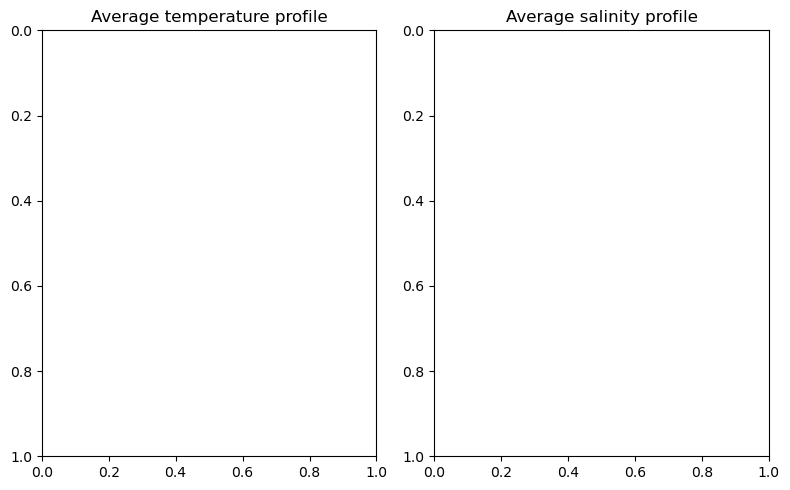

In [67]:
fig, ax = plt.subplots(1,2, figsize=(8,5))

for i, name in enumerate(['amundsen_sea','bellingshausen_sea','larsen','filchner_ronne','ross','amery','all']):
    ts_temp[name].plot(ax=ax[0], label=name, color=colors[i], linewidth=1.0)
    ts_salt[name].plot(ax=ax[1], label=name, color=colors[i], linewidth=1.0)

for axis in ax.ravel():
    axis.invert_yaxis()

ax[0].set_title('Average temperature profile')
ax[1].set_title('Average salinity profile')
ax[1].legend(frameon=False, loc=(1.0, 0.5))
fig.tight_layout()
# ax[1].plot(ts_amundsen_bwalt)

In [67]:
from matplotlib import colors as c

In [71]:
def setup_axes():

    fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
            
    return fig, ax

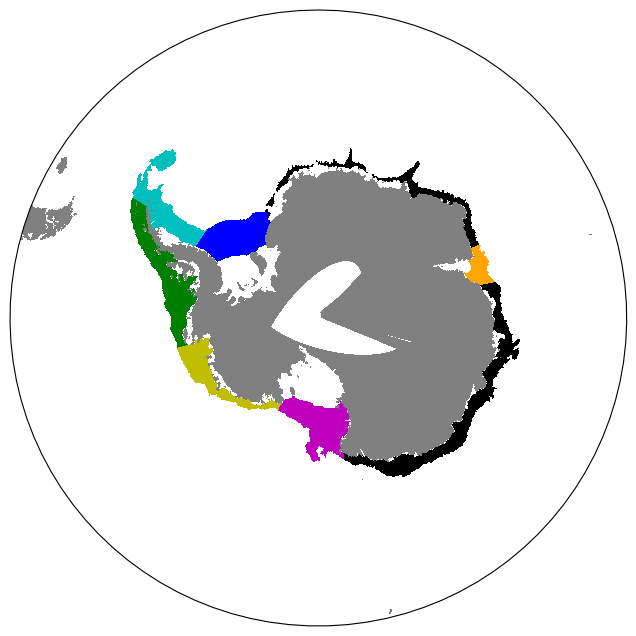

In [81]:
fig, ax = setup_axes()

plot_land = xr.where(nemo_mesh.top_level.isel(time_counter=0)==0, 1, np.nan)
cmap_land = c.ListedColormap(['gray'])

ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, plot_land,   transform=ccrs.PlateCarree(), cmap=cmap_land)
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['all']               , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['k']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['amundsen_sea']      , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['y']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['bellingshausen_sea'], transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['g']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['larsen']            , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['c']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['filchner_ronne']    , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['b']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['amery']             , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['orange']))
ax.pcolormesh(nemo_mesh.nav_lon, nemo_mesh.nav_lat, masked_regions['ross']              , transform=ccrs.PlateCarree(), cmap=c.ListedColormap(['m']))

# masked_regions['bellingshausen_sea'][0].plot(ax=ax)